# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [242]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data
dataset_dir = './dataset'
sign_names_file = './signnames.csv'

training_file = dataset_dir + '/train.p'
validation_file = dataset_dir + '/valid.p'
testing_file = dataset_dir + '/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


### Helper methods

In [244]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
import pickle
from tqdm import tqdm
from time import sleep
import os
import glob

def load_sign_names(sign_names_file='./signnames.csv'):
    """
    Loads the CSV file containing traffic sign names.
    :param sign_names_file: Path to the sign-names CSV file.
    :return: A list containing sign-names, indexed by_set their label-class-number (known).
    """
    signs_list = []
    with open(sign_names_file, mode='r') as labels_file:
        reader = csv.reader(labels_file)
        next(reader, None)
        for sign in reader:
            signs_list.append(sign[1])
    return signs_list

def visualize_dataset(X, y, sign_names):
    """
    Displays 12 images randomly from the given dataset.
    """
    # Divide the display region by 4x3 cells for displaying 12 random images.
    rows = 4
    columns = 3
    fig = plt.figure(figsize=(15,6))
    fig.subplots_adjust(hspace = .75, wspace=.001)
    for i in range(1, rows * columns + 1):
        img_idx = np.random.randint(0, len(X))
        sign_image = X[img_idx]
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(sign_names[y[img_idx]])
        ax.title.set_fontsize(10)
        plt.axis('off')
        plt.imshow(sign_image)

def describe_labels(y, sign_names, count_plot_name=None):
    """
    Provides insight on the count of each sign-label in the labels-set.
    """
    sign_dict = dict(zip([idx for idx in range(len(sign_names))], sign_names))
    y_labels = list(map(lambda sign_num : sign_names[sign_num], y))
    y_df = pd.DataFrame(y_labels, dtype=str, columns=['sign_name'])
    cnt_plot = sns.factorplot(x=y, data=y_df, kind='count', size=10, aspect=1.2, color=".4")
    cnt_plot.set_xlabels('Traffic sign class')
    cnt_plot.fig.suptitle(count_plot_name, size=24)
    # print('### Label index (vs) Sign name map ###')
    # print(pd.DataFrame(list(sign_dict.values()), columns=['Sign Name']))
    # print('\n')
    print('### Sign counts ###')
    print(y_df['sign_name'].value_counts())
    
def convert_to_grayscale(X):
    """
    Converts an RGB image having 3 channels to grayscale.
    :param X: RGB image set, each image represented as an ndarray.
    :return: Grayscale images.
    """
    return np.sum(X / 3, axis=3, keepdims=True)

def min_max_scale_grayscale_images(X, scale_min=0.1, scale_max=0.9):
    """
    Applies min-max scaling to make the pixel values fall in the range [scale_min, scale_max]
    :param X: Set of images, type ndarray.
    :return: Min-max scaled images.
    """
    grayscale_min = 0
    grayscale_max = 255
    return scale_min + ((X - grayscale_min) / (grayscale_max - grayscale_min)) * (scale_max - scale_min)

def normalize_images(X):
    return (X - np.mean(X)) / np.std(X)

def quick_normalize_images(X):
    return (X - 128) / 128
    
def preprocess_images(X):
    """
    Applies preprocessing pipeline on the images.
    :param X: Input image dataset.
    :return: Preprocessed image dataset.
    """
    X_gray = convert_to_grayscale(X)
    return normalize_images(X_gray)

def random_translate(img, trans_range=3):
    """
    Translates the image in both x and y directions.
    Range for pixel-translation is set to -2 to 2.
    :param img: Input image.
    :param trans_range: Range, in pixels, to translate the image by.
    :return: Translated image.
    """
    height,width = img.shape[:2]
    dx = dy = np.random.uniform(trans_range) - trans_range / 2
    translation_mat = np.float32([[1,0,dx],[0,1,dy]])
    return cv2.warpAffine(img, translation_mat, (height,width))

def random_shear(img, shear_range=10):
    """
    Shears the image (stretch or shrink) by defining a pair of three points.
    :param img: Input image.
    :param shear_range: Amount of shearing, in pixels, to be applied on the image.
    :return: Sheared image.
    """
    height,width = img.shape[:2]
    # Defining shear limits with a pair of 3-points.
    px = 5 + shear_range * np.random.uniform() - shear_range / 2
    py = 20 + shear_range * np.random.uniform() - shear_range / 2
    shear_src = np.float32([[5,5],[20,5],[5,20]])
    shear_dst = np.float32([[px,5],[py,px],[5,py]])
    shear_mat = cv2.getAffineTransform(shear_src, shear_dst)
    return cv2.warpAffine(img, shear_mat, (height,width))

def random_rotate(img, angle_range=20):
    """
    Rotates the image by a certain angle.
    :param img: Input image.
    :param angle_range: Range of the angle of rotation, in pixels.
    :return: Rotated image.
    """
    height,width = img.shape[:2]
    rot_angle = np.random.uniform(angle_range) - angle_range / 2
    rot_mat = cv2.getRotationMatrix2D((height/2,width/2), rot_angle, 1)
    return cv2.warpAffine(img, rot_mat, (height,width))

def random_brightness(img):
    r_brightness = 0.3 + np.random.uniform()
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_hsv[:,:,2] = r_brightness * img_hsv[:,:,2]
    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

def augment_jitter_data(X, y, min_num_samples=750):
    num_classes = len(np.unique(y))
    print('Augmenting data for classes which have < {} samples ..'.format(min_num_samples))
    augmented_train_set = {}
    for sample_class in range(num_classes):
        sample_indices = np.where(sample_class == y)
        num_samples = len(sample_indices[0])
        if num_samples < min_num_samples:
            print('\nClass {}: {} samples, {} samples to augment'.format(sample_class, num_samples, min_num_samples-num_samples))
            sleep(0.1)
            # Augment samples for this class by applying geometric transformation on existing images
            # having the same class.
            for i in range(min_num_samples - num_samples):
                img = X[sample_indices[0][i % num_samples]]
                transformed_img = random_shear(random_translate(random_rotate(random_brightness(img))))
                X = np.concatenate((X, [transformed_img]), axis=0)
                y = np.concatenate((y, [sample_class]), axis=0)
            sleep(0.5)
    augmented_train_set['features'] = X
    augmented_train_set['labels'] = y
    pickle.dump(augmented_train_set, open('augmented_train.p', 'wb'))
    return X, y


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [245]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Image dimensions: {}".format(X_train[0].shape))
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Image dimensions: (32, 32, 3)
Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples
Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

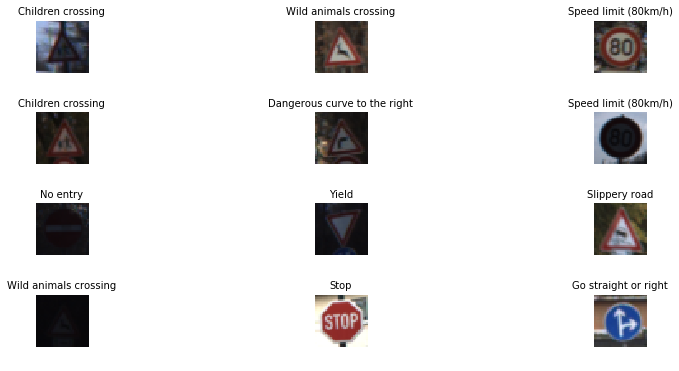

In [246]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

sign_names = load_sign_names()
visualize_dataset(X_train, y_train, sign_names)


### Sign counts ###
Speed limit (50km/h)                                  2010
Speed limit (30km/h)                                  1980
Yield                                                 1920
Priority road                                         1890
Keep right                                            1860
No passing for vehicles over 3.5 metric tons          1800
Speed limit (70km/h)                                  1770
Speed limit (80km/h)                                  1650
Road work                                             1350
No passing                                            1320
Speed limit (100km/h)                                 1290
Speed limit (60km/h)                                  1260
Speed limit (120km/h)                                 1260
Right-of-way at the next intersection                 1170
Ahead only                                            1080
General caution                                       1080
No entry                            

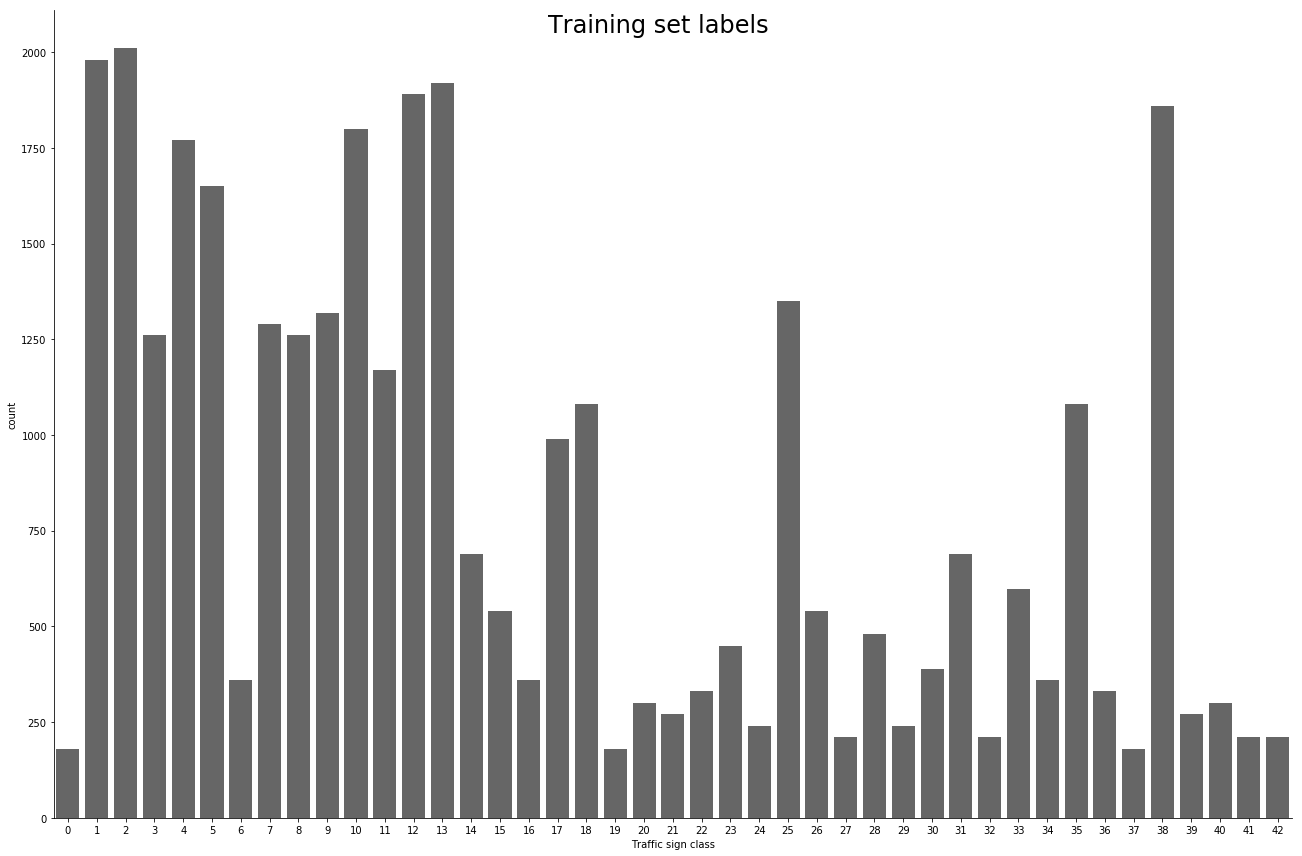

In [5]:
describe_labels(y_train, sign_names, 'Training set labels')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
# Augmenting jitter data to classes/labels which have less than 1000 samples.
# Augmented data is picked from existing images (having the same label) and is obtained by
# performing geometric-transformations on those images, as
# CNNs are invariant to such transformations (rotation, translation, shearing, etc.).
# X_train, y_train = augment_jitter_data(X_train, y_train)
# print(X_train.shape)

### Sign counts ###
Speed limit (50km/h)                                  2010
Speed limit (30km/h)                                  1980
Yield                                                 1920
Priority road                                         1890
Keep right                                            1860
No passing for vehicles over 3.5 metric tons          1800
Speed limit (70km/h)                                  1770
Speed limit (80km/h)                                  1650
Road work                                             1350
No passing                                            1320
Speed limit (100km/h)                                 1290
Speed limit (120km/h)                                 1260
Speed limit (60km/h)                                  1260
Right-of-way at the next intersection                 1170
General caution                                       1080
Ahead only                                            1080
No entry                            

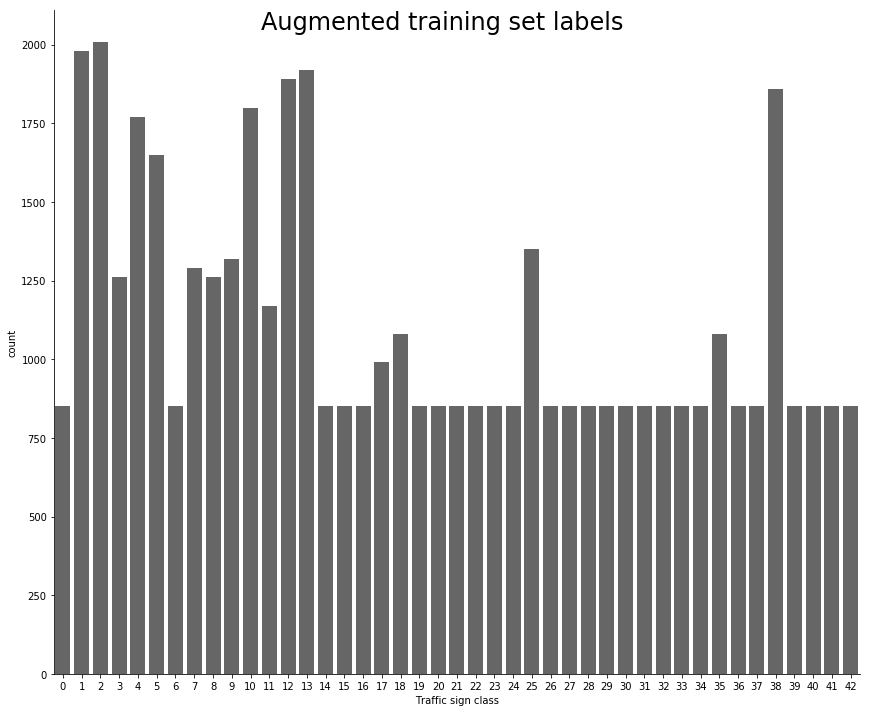

In [247]:
with open('augmented_train.p', mode='rb') as f:
    train = pickle.load(f)
X_train, y_train = train['features'], train['labels']
X_train = preprocess_images(X_train)
X_valid = preprocess_images(X_valid)
X_test = preprocess_images(X_test)
describe_labels(y_train, sign_names, 'Augmented training set labels')

### Model Architecture

In [254]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    return tf.nn.bias_add(x, b)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

def build_lenet(x, keep_prob=0.5):
    '''
    LeNet architecture with dropout applied for the activations of fully-connected layers.
    '''
    mu = 0
    sigma = 0.1

    weights = {
        'fw1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma)),
        'fw2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma)),
        'fcw1': tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma)),
        'fcw2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma)),
        'fcw3': tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    }

    biases = {
        'b1': tf.Variable(tf.zeros(6)),
        'b2': tf.Variable(tf.zeros(16)),
        'fcb1': tf.Variable(tf.zeros(120)),
        'fcb2': tf.Variable(tf.zeros(84)),
        'fcb3': tf.Variable(tf.zeros(43))
    }

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['fw1'], biases['b1'])

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['fw2'], biases['b2'])

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)

    # Flatten. Input = 5x5x16. Output = 400.
    conv2 = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    conv3 = tf.add(tf.matmul(conv2, weights['fcw1']), biases['fcb1'])

    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Dropout.
    conv3 = tf.nn.dropout(conv3, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    conv4 = tf.add(tf.matmul(conv3, weights['fcw2']), biases['fcb2'])

    # Activation.
    conv4 = tf.nn.relu(conv4)
    
    # Dropout.
    conv4 = tf.nn.dropout(conv4, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(conv4, weights['fcw3']), biases['fcb3'])
    return logits

def build_lenet2(x, keep_prob=0.5):
    '''
    LeNet architecture with a trial on passing activations of a non-penultimate layer
    (with respect to classification-layer)to the classifier. Inspired by Sermanet '11 paper.
    '''
    mu = 0
    sigma = 0.1

    weights = {
        'fw1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma)),
        'fw2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma)),
        'fw3': tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean=mu, stddev=sigma)),
        'fcw1': tf.Variable(tf.truncated_normal(shape=(800, 43), mean=mu, stddev=sigma))
    }

    biases = {
        'b1': tf.Variable(tf.zeros(6)),
        'b2': tf.Variable(tf.zeros(16)),
        'b3': tf.Variable(tf.zeros(400)),
        'fcb1': tf.Variable(tf.zeros(43))
    }

    ### Stage 0.
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['fw1'], biases['b1'])

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)

    ### Stage 1. Outputs from this stage are also passed to the (first) fully-connected layer.
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['fw2'], biases['b2'])

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)
    layer2 = conv2  # To be used in the classifier.

    # Layer 3: Convolutional. Input = 5x5x16. Output = 1x1x400
    conv3 = conv2d(conv2, weights['fw3'], biases['b3'])

    # Activation.
    conv3 = tf.nn.relu(conv3)

    # Flatten layer2 and output from layer 3 and concat them.
    layer2_flat = flatten(layer2)
    layer3_flat = flatten(conv3)
    conv3 = tf.concat_v2([layer2_flat, layer3_flat], 1)

    # Dropout.
    conv3 = tf.nn.dropout(conv3, keep_prob)

    # Layer 4: Fully Connected. Input = 800. Output = 43.
    logits = tf.add(tf.matmul(conv3, weights['fcw1']), biases['fcb1'])
    return logits

def build_lenet3(x, keep_prob=0.5):
    '''
    LeNet architecture with dropout applied for the activations of fully-connected layers.
    '''
    mu = 0
    sigma = 0.1

    weights = {
        'fw1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma)),
        'fw2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma)),
        'fcw1': tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma)),
        'fcw2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma)),
        'fcw3': tf.Variable(tf.truncated_normal(shape=(84, 60), mean=mu, stddev=sigma)),
        'fcw4': tf.Variable(tf.truncated_normal(shape=(60, 43), mean=mu, stddev=sigma))
    }

    biases = {
        'b1': tf.Variable(tf.zeros(6)),
        'b2': tf.Variable(tf.zeros(16)),
        'fcb1': tf.Variable(tf.zeros(120)),
        'fcb2': tf.Variable(tf.zeros(84)),
        'fcb3': tf.Variable(tf.zeros(60)),
        'fcb4': tf.Variable(tf.zeros(43))
    }

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['fw1'], biases['b1'])

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['fw2'], biases['b2'])

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)

    # Flatten. Input = 5x5x16. Output = 400.
    conv2 = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    conv3 = tf.add(tf.matmul(conv2, weights['fcw1']), biases['fcb1'])

    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Dropout.
    conv3 = tf.nn.dropout(conv3, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    conv4 = tf.add(tf.matmul(conv3, weights['fcw2']), biases['fcb2'])

    # Activation.
    conv4 = tf.nn.relu(conv4)
    
    # Dropout.
    conv4 = tf.nn.dropout(conv4, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 60.
    conv5 = tf.add(tf.matmul(conv4, weights['fcw3']), biases['fcb3'])

    # Activation.
    conv5 = tf.nn.relu(conv5)
    
    # Dropout.
    conv5 = tf.nn.dropout(conv5, keep_prob)

    # Layer 6: Fully Connected. Input = 60. Output = 43.
    logits = tf.add(tf.matmul(conv5, weights['fcw4']), biases['fcb4'])
    return logits

### Training operations

In [255]:
import tensorflow as tf
from sklearn.utils import shuffle

# Hyper parameters.
learning_rate = 0.0009
EPOCHS = 75
BATCH_SIZE = 128

tf.reset_default_graph() 

# Placeholders for input features and labels.
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)  # Probability with which units' will be dropped out.
one_hot_y = tf.one_hot(y, n_classes)

logits = build_lenet3(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

### Model evaluation

In [256]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

### Training routine.

Training...

EPOCH 1 ...
Validation Accuracy = 0.434

EPOCH 2 ...
Validation Accuracy = 0.627

EPOCH 3 ...
Validation Accuracy = 0.719

EPOCH 4 ...
Validation Accuracy = 0.821

EPOCH 5 ...
Validation Accuracy = 0.823

EPOCH 6 ...
Validation Accuracy = 0.833

EPOCH 7 ...
Validation Accuracy = 0.846

EPOCH 8 ...
Validation Accuracy = 0.861

EPOCH 9 ...
Validation Accuracy = 0.869

EPOCH 10 ...
Validation Accuracy = 0.885

EPOCH 11 ...
Validation Accuracy = 0.888

EPOCH 12 ...
Validation Accuracy = 0.901

EPOCH 13 ...
Validation Accuracy = 0.918

EPOCH 14 ...
Validation Accuracy = 0.907

EPOCH 15 ...
Validation Accuracy = 0.913

EPOCH 16 ...
Validation Accuracy = 0.908

EPOCH 17 ...
Validation Accuracy = 0.918

EPOCH 18 ...
Validation Accuracy = 0.917

EPOCH 19 ...
Validation Accuracy = 0.922

EPOCH 20 ...
Validation Accuracy = 0.921

EPOCH 21 ...
Validation Accuracy = 0.922

EPOCH 22 ...
Validation Accuracy = 0.930

EPOCH 23 ...
Validation Accuracy = 0.915

EPOCH 24 ...
Validation Accura

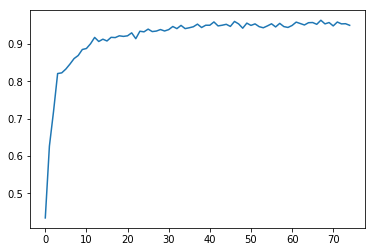

Model saved


In [257]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    epochs = []
    v_accuracy = []
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})

        validation_accuracy = evaluate(X_valid, y_valid)
        epochs.append(i)
        v_accuracy.append(validation_accuracy)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    plt.plot(epochs, v_accuracy)
    plt.show()
    saver.save(sess, './lenet')
    print("Model saved")

### Validation accuracy log

- Vanilla LeNet


|Batch Size|Epochs | Learning Rate | Preprocessing steps                  | Dropout present | Validation accuracy | Comments            |
|----------|:-----:|:-------------:|:------------------------------------:|:---------------:|:-------------------:|--------------------:|
|128       |30     | 0.001         | Grayscale, min-max scaling [0.1,0.9] | no              | ~ 0.91              |                     |
|128       |30     | 0.001         | Grayscale, quick normalization       | no              | ~ 0.92              |                     |
|128       |50     | 0.001         | Grayscale, quick normalization       | no              | ~ 0.92              |                     |
|128       |75     | 0.001         | Grayscale, standard normalization    | no              | > 0.93, < 0.95      | high accuracy jumps |
|128       |100    | 0.001         | Grayscale, standard normalization    | no              | > 0.93, < 0.95      | high accuracy jumps |
|128       |75     | 0.0009        | Grayscale, standard normalization    | no              | ~ 0.94              | low accuracy jumps  | 
|128       |75     | 0.0009        | Grayscale, standard normalization    | 0.5             | <= 0.964            | regularization!     | 
|128       |75     | 0.0009        | same as above + Augmented train (750)| 0.5             | ~ 0.964, 0.965      | Jitter pipeline!    | 
|128       |75     | 0.0009        | same as above + Augmented train (750)| 0.25            | ~ 0.917             |Activations did not generalize well| 
|256       |75     | 0.0009        | same as above + Augmented train (750)| 0.5             | ~ 0.962             |Higher batch size, no improvement| 
|128       |75     | 0.0009        | same as above + Augmented train (850)| 0.5             | ~ 0.966, 0.967      |extra 100 samples augmented!| 


- LeNet with few modifications inspired from Sermanet '11 paper on Traffic Sign classification.

|Batch Size|Epochs | Learning Rate | Preprocessing steps                  | Dropout present | Validation accuracy | Comments            |
|----------|:-----:|:-------------:|:------------------------------------:|:---------------:|:-------------------:|--------------------:|
|128       |75     | 0.0009        | graysclale,normalized,augmented (850)| 0.5             | ~ 0.957             |bit jumpy, no performance improvement with hacky implementation of Sermanet|  


- LeNet with one additional fully-connected layer, making it a total of 3 fully-connected layers.

|Batch Size|Epochs | Learning Rate | Preprocessing steps                  | Dropout present | Validation accuracy | Comments            |
|----------|:-----:|:-------------:|:------------------------------------:|:---------------:|:-------------------:|--------------------:|
|128       |75     | 0.0009        | graysclale,normalized,augmented (850)| 0.5             | ~ 0.955             |bit jumpy near highs, no performance improvement|  



### Testing routine

In [69]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
print('Test accuracy {:.3f}'.format(test_accuracy))

Test accuracy 0.9426761675522805


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

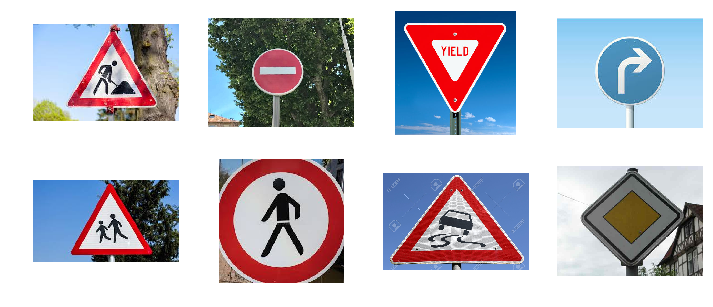

In [212]:
### Load the images and plot them here.
def load_test_images(path='dataset/test_images/*.jpg'):
    test_images = []
    test_images_scaled = []
    fig, ax = plt.subplots(2, 4, figsize=(12,5))
    ax = ax.ravel()
    for i, img in enumerate(glob.glob(os.getcwd()+'/'+path)):
        image = cv2.imread(img)
        ax[i].axis('off')
        ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        test_images.append(image)
        test_images_scaled.append(cv2.resize(image, (32,32)))
    return np.asarray(test_images), np.asarray(test_images_scaled)

test_images, test_images_scaled = load_test_images()
test_labels = [25, 17, 13, 33, 28, 27, 23, 12]

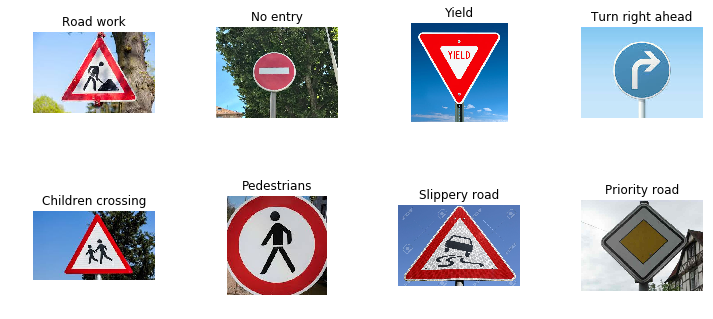

In [214]:
# Display preprocessed test images.
fig, ax = plt.subplots(2, 4, figsize=(12,5))
fig.subplots_adjust(hspace=.75, wspace=.5)
ax = ax.ravel()
for i in range(len(test_images)):
    ax[i].axis('off')
    ax[i].set_title(sign_names[test_labels[i]])
    ax[i].imshow(cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB))

### Predict the Sign Type for Each Image

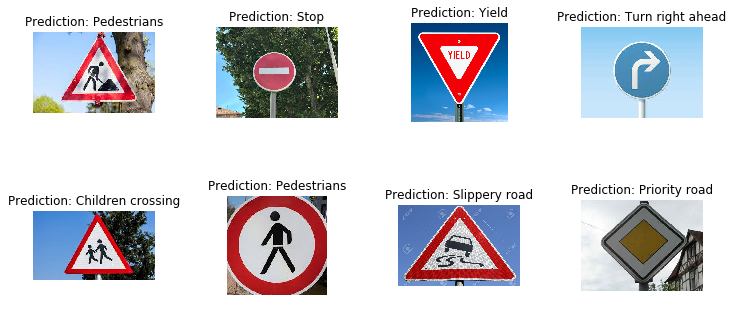

In [215]:
def predict(image, model):
    with tf.Session() as sess:
        saver.restore(sess, './' + model)
        prediction = tf.argmax(logits, 1)
        return prediction.eval(feed_dict={x: image[np.newaxis,:,:,:], keep_prob: 1.0})
    
test_images_normalized = preprocess_images(test_images_scaled)

# Display predictions.
fig, ax = plt.subplots(2, 4, figsize=(12,5))
fig.subplots_adjust(hspace=.75, wspace=.5)
ax = ax.ravel()
for i in range(len(test_images)):
    prediction = predict(test_images_normalized[i], 'lenet')
    prediction = np.asscalar(prediction)
    ax[i].axis('off')
    ax[i].set_title("Prediction: " + sign_names[prediction])
    ax[i].imshow(cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB))

### Analyze Performance

#### Accuracy on new images.

Above prediction on 8 road signs show that there is a 87.5% accuracy. _Road work_ sign (class number 25) is incorrectly predicted as _pedestrians_.


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [232]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
def print_top_k_softmax(test_image, model, k=5):
    with tf.Session() as sess:
        saver.restore(sess, './' + model)
        # Softmax predictions on this test-image.
        softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: test_image[np.newaxis,:,:,:], keep_prob: 1.0})
        # Return top-k softmax probabilities predicted on this test-image.
        return sess.run(tf.nn.top_k(softmax, k))

def print_softmax_predictions(pred):
    '''
    Prints softmax-predictions in ascending order, with the class-label having highest probability on top.
    '''
    # Index 0 has tuple of probabilities.
    # Index 1 has tuple of class-label indices.
    for i in range(len(pred[0][0])):
        print('{} : {:.3f}%'.format(sign_names[pred[1][0][i]], pred[0][0][i] * 100))

In [236]:
# Predictions for Road-work sign.
softmax_predictions = print_top_k_softmax(test_images_normalized[0], 'lenet')
print('Softmax predictions for Road Work sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Road Work sign..
Pedestrians : 33.832%
Road narrows on the right : 19.983%
Double curve : 11.526%
Go straight or left : 7.922%
Traffic signals : 5.437%


In [234]:
# Predictions for Stop sign.
softmax_predictions = print_top_k_softmax(test_images_normalized[1], 'lenet')
print('Softmax predictions for Stop sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Stop sign..
Stop : 32.088%
Turn right ahead : 27.080%
Speed limit (70km/h) : 19.334%
Keep left : 9.745%
No vehicles : 7.269%


In [235]:
softmax_predictions = print_top_k_softmax(test_images_normalized[2], 'lenet')
print('Softmax predictions for Yield sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Yield sign..
Yield : 100.000%
Speed limit (60km/h) : 0.000%
Turn left ahead : 0.000%
No vehicles : 0.000%
Keep right : 0.000%


In [237]:
softmax_predictions = print_top_k_softmax(test_images_normalized[3], 'lenet')
print('Softmax predictions for Turn Right Ahead sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Turn Right Ahead sign..
Turn right ahead : 69.764%
Stop : 9.358%
Go straight or right : 5.766%
Turn left ahead : 5.600%
Ahead only : 5.378%


In [238]:
softmax_predictions = print_top_k_softmax(test_images_normalized[4], 'lenet')
print('Softmax predictions for Children Crossing sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Children Crossing sign..
Children crossing : 99.959%
Dangerous curve to the left : 0.016%
Slippery road : 0.013%
Go straight or right : 0.013%
Right-of-way at the next intersection : 0.000%


In [239]:
softmax_predictions = print_top_k_softmax(test_images_normalized[5], 'lenet')
print('Softmax predictions for Pedestrians sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Pedestrians sign..
Pedestrians : 49.258%
Double curve : 18.883%
Road narrows on the right : 16.769%
Traffic signals : 12.283%
General caution : 1.891%


In [240]:
softmax_predictions = print_top_k_softmax(test_images_normalized[6], 'lenet')
print('Softmax predictions for Slippery Road sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Slippery Road sign..
Slippery road : 68.025%
Children crossing : 22.049%
Beware of ice/snow : 6.108%
Dangerous curve to the right : 3.557%
Dangerous curve to the left : 0.199%


In [241]:
softmax_predictions = print_top_k_softmax(test_images_normalized[7], 'lenet')
print('Softmax predictions for Priority Road sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Priority Road sign..
Priority road : 99.999%
Roundabout mandatory : 0.000%
End of no passing by vehicles over 3.5 metric tons : 0.000%
Turn left ahead : 0.000%
End of no passing : 0.000%


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [18]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")